In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Defined the model files
FACE_PROTO = "weights/opencv_face_detector.pbtxt"
FACE_MODEL = "weights/opencv_face_detector_uint8.pb"

AGE_PROTO = "weights/age_deploy.prototxt"
AGE_MODEL = "weights/age_net.caffemodel"

GENDER_PROTO = "weights/gender_deploy.prototxt"
GENDER_MODEL = "weights/gender_net.caffemodel"

# Load network
FACE_NET = cv2.dnn.readNet(FACE_MODEL, FACE_PROTO)
AGE_NET = cv2.dnn.readNet(AGE_MODEL, AGE_PROTO)
GENDER_NET = cv2.dnn.readNet(GENDER_MODEL, GENDER_PROTO)

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
AGE_LIST = ["(0-2)", "(4-6)", "(8-12)", "(15-20)", "(25-32)", "(38-43)", "(48-53)", "(60-100)"]
GENDER_LIST = ["Male", "Female"]

box_padding = 20

def get_face_box(net, frame, conf_threshold=0.7):
    frame_copy = frame.copy()
    frame_height = frame_copy.shape[0]
    frame_width = frame_copy.shape[1]
    blob = cv2.dnn.blobFromImage(frame_copy, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    boxes = []

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frame_width)
            y1 = int(detections[0, 0, i, 4] * frame_height)
            x2 = int(detections[0, 0, i, 5] * frame_width)
            y2 = int(detections[0, 0, i, 6] * frame_height)
            boxes.append([x1, y1, x2, y2])
            cv2.rectangle(frame_copy, (x1, y1), (x2, y2), (0, 255, 0), int(round(frame_height / 150)), 8)

    return frame_copy, boxes

def age_gender_detector(input_path):
    image = cv2.imread(input_path)
    resized_image = cv2.resize(image, (640, 480))

    frame = resized_image.copy()
    frame_face, boxes = get_face_box(FACE_NET, frame)

    for box in boxes:
        face = frame[max(0, box[1] - box_padding):min(box[3] + box_padding, frame.shape[0] - 1), \
                     max(0, box[0] - box_padding):min(box[2] + box_padding, frame.shape[1] - 1)]

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        GENDER_NET.setInput(blob)
        gender_predictions = GENDER_NET.forward()
        gender = GENDER_LIST[gender_predictions[0].argmax()]
        print("Gender: {}, conf: {:.3f}".format(gender, gender_predictions[0].max()))

        AGE_NET.setInput(blob)
        age_predictions = AGE_NET.forward()
        age = AGE_LIST[age_predictions[0].argmax()]
        print("Age: {}, conf: {:.3f}".format(age, age_predictions[0].max()))

        label = "{},{}".format(gender, age)
        cv2.putText(frame_face, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)

    return resized_image, frame_face

# Function to display images in Jupyter notebook
def show_image(image, title="Image"):
    # Convert the image from BGR (OpenCV default) to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 5))
    plt.imshow(rgb_image)
    plt.title(title)
    plt.axis("off")
    plt.show()

Gender: Male, conf: 1.000
Age: (38-43), conf: 0.927
Gender: Male, conf: 0.855
Age: (60-100), conf: 0.647


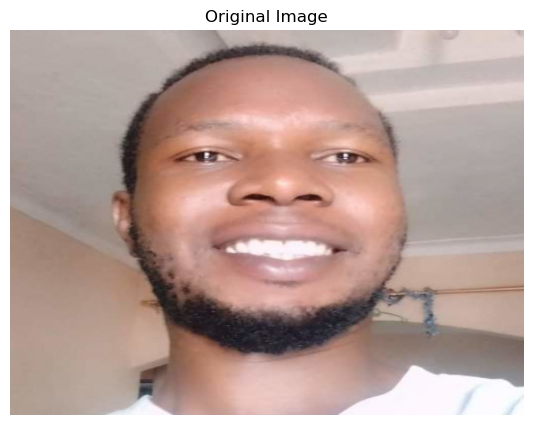

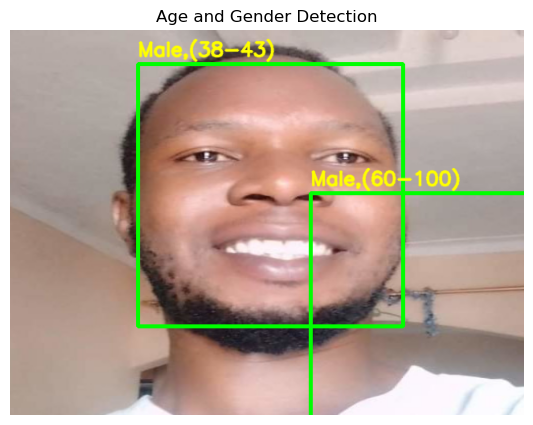

In [16]:
# Run the detection and show the original and processed images
input_image_path = "yasin.jpg"  
original_image, output_image = age_gender_detector(input_image_path)

# Show original image
show_image(original_image, title="Original Image")

# Show processed image with detected age and gender
show_image(output_image, title="Age and Gender Detection")